In [2]:
from imports_func import *
from dbase import *

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_full.npy') 
#X2=np.load('/home/miquel/ForMiquel/CLEAN2/X_c2_1j.npy')
#X3=np.load('/home/miquel/ForMiquel/CLEAN2/X_c3_1j.npy')
#X=np.concatenate((X1, X2), axis=1)
#X=np.concatenate((X, X3), axis=1)
y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_full.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_full.npy')

In [4]:
# build vector with dt's
dt=[]
for i in range(0,len(sub_id)):
    dt.append(Subjects[sub_id[i]].jacobians[jac_idx[i]].dt)

dt = np.asarray(dt)/365 
#dt=np.reshape(dt, (124,1))

In [5]:
def KFold(X, y, splits, linspace, dt, percentage, feat):
    
    l=len(linspace)
    l2=X.shape[1]
    ACC=np.zeros((l))
    ROC=np.zeros((l))
    F1=np.zeros((l))
    MCC=np.zeros((l))
    APS=np.zeros((l))
    PREC=np.zeros((l))
    REC=np.zeros((l))
    
    
    dt=np.reshape(dt, (124,1))
    
    kf = cross_validation.KFold(124, n_folds=splits)
    spl2 = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)

    for train_index, test_index in kf:  
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
     
    #for train_index, test_index in spl2.split(X, y):
    #    X_train = X[train_index,:]
    #    y_train = y[train_index]
    #    X_test = X[test_index,:]
    #    y_test = y[test_index]
    #    dt_test = dt[test_index]
        
        acc_l=[]
        roc_l=[]
        f1_l=[]
        mcc_l=[]
        aps_l=[]
        prec_l=[]
        rec_l=[]
        
        for c in linspace:
            
            y_test = y[test_index]
            dt_test = dt[test_index]
            
            print(c)
            S = SelectPercentile(percentile=percentage)
            S.fit(X_train, y_train)
            
            if feat == 0:
                X_train_s = X_train[:,S.get_support()]
                X_test_s = X_test[:,S.get_support()]
            
            if feat !=0:
                pvalues = np.transpose(S.pvalues_) 
                pvalues = np.reshape(pvalues,l2)
                #feat=feat.astype(int)
                idxs=pvalues.argsort()[-feat:][::-1]
                idxs=np.sort(idxs)
                mask = np.zeros(l2, dtype=bool)
                mask[idxs]=True
                X_train_s=X_train[:,mask] #take columns of features with large (abs value) weights
                X_test_s=X_test[:,mask]
                print(np.shape(X_train_s))

            
            
            clf = LogisticRegression(solver='liblinear', penalty='l2',class_weight='balanced', C=c)
            y_score = clf.fit(X_train_s, y_train).decision_function(X_test_s)
            pred = clf.predict(X_test_s)
            
            mask0 = np.where(dt_test>1.09)#~400 days
            mask0 = np.asarray(mask0)
            pred = pred[mask0][0]
            y_test = y_test[mask0][0]
            y_score = y_score[mask0][0]
            print(pred)
            print(y_test)
            print(y_score)
            
                
            acc = accuracy_score(y_test, pred)
            roc=roc_auc_score(y_test, y_score)
            f1=f1_score(y_test, pred)
            mcc=matthews_corrcoef(y_test, pred)
            aps=average_precision_score(y_test, y_score)
            precision=precision_score(y_test, pred)
            recall=recall_score(y_test, pred)
            
            acc_l.append(acc)
            roc_l.append(roc)
            f1_l.append(f1)
            mcc_l.append(mcc)
            aps_l.append(aps)
            prec_l.append(precision)
            rec_l.append(recall)
            
        ACC = np.vstack((ACC, acc_l))
        ROC = np.vstack((ROC, roc_l))
        F1 = np.vstack((F1, f1_l))
        MCC = np.vstack((MCC, mcc_l))
        APS = np.vstack((APS, aps_l))
        PREC = np.vstack((PREC, prec_l))
        REC = np.vstack((REC, rec_l))
        print(PREC.shape)
        
            
    ACC=ACC[1:,:]
    ROC=ROC[1:,:]
    F1=F1[1:,:]
    MCC=MCC[1:,:]
    APS=APS[1:,:]
    PREC=PREC[1:,:]
    REC=REC[1:,:]
    
    
    m1=np.mean(ACC, axis=0)
    dv1=np.std(ACC, axis=0)
    m2=np.mean(ROC, axis=0)
    dv2=np.std(ROC, axis=0)
    m3=np.mean(F1, axis=0)
    dv3=np.std(F1, axis=0)
    m4=np.mean(MCC, axis=0)
    dv4=np.std(MCC, axis=0)
    m5=np.mean(APS, axis=0)
    dv5=np.std(APS, axis=0)
    m6=np.mean(PREC, axis=0)
    dv6=np.std(PREC, axis=0)
    m7=np.mean(REC, axis=0)
    dv7=np.std(REC, axis=0)
    
    plt.figure(1)
    plt.plot(linspace, m1, color='green', label='acc')
    plt.plot(linspace, m2, color='red', label='roc')
    plt.plot(linspace, m3, color='blue', label='f1_score')
    plt.plot(linspace, m4, color='orange', label='mcc')
    plt.plot(linspace, m5, color='black', label='aps')
    plt.plot(linspace, m6, color='brown', label='precision')
    plt.plot(linspace, m7, color='yellow', label='recall')

    
    

    plt.legend(loc='best')
    plt.xlabel('C')
    plt.title('metrics logistic regression combination c1 and c2')
    plt.show()
    
    return m2, m5
    

0.01


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    149    173 ..., 573779 573824 573839] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[1 1 1 0 1 1 1 1 0]
[1 0 0 0 0 0 0 1 1]
[ 0.08976479  0.04554583  0.03720609 -0.00013739  0.02349193  0.00457099
  0.01138032  0.07875385 -0.01197932]
0.535789473684
[1 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 1 1]
[ 0.54979624 -0.15109671 -0.06602385 -0.53393179 -0.38779979 -0.56407688
 -0.60994352 -0.02778892 -1.10532036]
1.06157894737
[1 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 1 1]
[ 0.87530268 -0.26677699 -0.04109445 -0.56921029 -0.44152852 -0.69736636
 -0.74630713 -0.17796818 -1.3951977 ]
1.58736842105
[1 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 1 1]
[ 1.16038342 -0.36407178 -0.01654445 -0.54821567 -0.43938642 -0.76640341
 -0.79734205 -0.30276053 -1.52343532]
2.11315789474
[1 0 1 0 0 0 0 0 0]
[1 0 0 0 0 0 0 1 1]
[ 1.41330612 -0.4509192   0.00214371 -0.51572072 -0.42114225 -0.81190832
 -0.81840603 -0.41043774 -1.59058744]
2.63894736842
[1 0 1 0 0 0 0 0 0]
[1 0 0 0 0 0 0 1 1]
[ 1.6399218  -0.5295893   0.01659914 -0.48192702 -0.3978851  -0.84596205
 -0.82664926 -0.50517111 -1.62912502]
3.16473684211
[1 0 1 0 

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 573555 573776 573777] are constant.
  UserWarning)


[1 1 1 1 1 1 1 1 1]
[0 1 1 0 1 0 0 0 1]
[ 0.11075531  0.18085384  0.27795457  0.07758007  0.26280785  0.00735469
  0.11144001  0.11385798  0.04803735]
0.535789473684


/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[1 1 1 1 1 0 1 1 0]
[0 1 1 0 1 0 0 0 1]
[ 0.63619268  1.38600632  2.20776692  0.36135243  2.97230144 -0.60393894
  0.63282471  0.73447454 -0.02844979]
1.06157894737
[1 1 1 1 1 0 1 1 0]
[0 1 1 0 1 0 0 0 1]
[ 0.71383807  1.45080627  2.37953994  0.41893612  3.7822932  -0.83117055
  0.68069671  0.82785877 -0.12521465]
1.58736842105
[1 1 1 1 1 0 1 1 0]
[0 1 1 0 1 0 0 0 1]
[ 0.73465069  1.40616206  2.37123799  0.44087097  4.26677812 -0.98452731
  0.69810488  0.86744893 -0.20270464]
2.11315789474
[1 1 1 1 1 0 1 1 0]
[0 1 1 0 1 0 0 0 1]
[ 0.73083245  1.33700924  2.31211265  0.44576131  4.6095386  -1.10784885
  0.70949356  0.88870852 -0.26668214]
2.63894736842
[1 1 1 1 1 0 1 1 0]
[0 1 1 0 1 0 0 0 1]
[ 0.71448054  1.2639607   2.23730068  0.44150466  4.8737229  -1.21427974
  0.71975203  0.90156843 -0.32116905]
3.16473684211
[1 1 1 1 1 0 1 1 0]
[0 1 1 0 1 0 0 0 1]
[ 0.69088895  1.19307344  2.15803456  0.43160132  5.08761386 -1.30875829
  0.73030368  0.9105346  -0.36864633]
3.69052631579
[1 1 1 1 1

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   196    275    289 ..., 573904 573905 573906] are constant.
  UserWarning)


[1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1]
[0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1]
[ 0.04200564  0.01763815  0.07022557  0.08814191  0.19199054  0.07339599
  0.06221183 -0.0760714   0.05662508  0.09340175  0.20630226  0.00748824
 -0.05907192  0.16609058  0.0462998   0.01028233]
0.535789473684
[0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1]
[0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1]
[-0.20779319 -0.61181903 -0.15949338  0.15159951  1.72652598  0.29658137
  0.06797316 -1.80784351  0.0264845   0.07362889  1.20554257 -0.5927819
 -1.39464902  0.81597148 -0.30863304  0.05475997]
1.06157894737
[0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1]
[0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1]
[-0.29543186 -0.86394533 -0.39138666  0.07458941  2.24550312  0.32532877
  0.05898321 -2.38021752  0.01136194 -0.01010396  1.35454112 -0.77474843
 -1.79158569  0.80599867 -0.49913651  0.27612996]
1.58736842105
[0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1]
[0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1]
[ -3.54062739e-01  -1.03499513e+00  -5.81993251e-01   1.70866430e-03
   2.58661569e+00   3.2668044

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   175    176    177 ..., 573919 573920 573921] are constant.
  UserWarning)


[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
[1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1]
[ 0.1089785   0.01382794  0.03958122  0.1026107   0.08258516 -0.01103692
  0.02395007  0.04377389  0.01386413  0.01977049  0.06602736  0.07365044
  0.05957684  0.01571619  0.19372375  0.03846054  0.10456139  0.09960818
  0.09459423  0.10823316  0.06299004 -0.06830971  0.0358819   0.04603409
  0.05662242]
0.535789473684
[1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1]
[1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1]
[ 0.08484755  0.14092434 -0.18224527  0.46245354  0.06281185 -0.57966814
 -0.2840519  -0.13215082 -0.51225612 -0.47686875 -0.05611768 -0.07683939
  0.4044169  -0.01435582  1.20579999 -0.15950141 -0.07319784  0.33539273
  0.14580764  0.64717551 -0.21420867 -1.38971868 -0.62676596 -0.15751676
  0.1906174 ]
1.06157894737
[0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1]
[1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1]
[ -8.75434839e-02   3.67171626e-01  -2.65610654

0.01


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 573912 573913 573914] are constant.
  UserWarning)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1]
[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0]
[ 0.13405179  0.08863371  0.09729618  0.12613989  0.09399203  0.08477211
  0.11418468  0.04757225  0.05450717  0.0664707   0.15752164  0.06927574
  0.02421492  0.06438471  0.0239937   0.08374629  0.05543876 -0.04627983
  0.08480137  0.31852438 -0.02465488  0.05026556  0.12140654  0.05524065]
0.535789473684
[0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0]
[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0]
[ -3.26360111e-02   3.19064145e-01  -5.09721104e-02   3.20263959e-01
  -3.01933724e-01  -3.23773993e-01   2.95377916e-01  -3.55664691e-01
  -3.38731146e-01   2.43992591e-02   2.90145738e-02  -1.82953280e-03
  -5.00646175e-01  -5.85457490e-01  -2.26184349e-01   3.91789768e-01
  -1.47798683e-02  -4.68003212e-01  -3.16483115e-01   2.51019302e+00
  -5.36550748e-01  -8.12645203e-02   2.09137809e-02  -2.48813474e-01]
1.06157894737
[0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0]
[0 1 0 0 0 0 

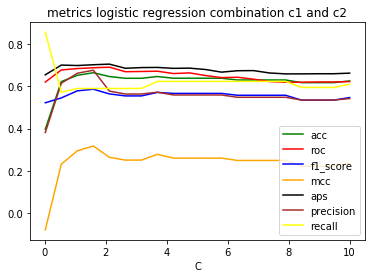

In [6]:
#X=np.transpose(np.transpose(X)/dt)
linspace = np.linspace(10e-3, 10, num=20)
splits=5
percentage=1.75
feat=0
roc, aps = KFold(X, y, splits, linspace, dt, percentage, feat)
